# Zero model

まずはスタート地点として『ゼロから作るDeep Learning』の８章のＣＮＮを PyTorch で実装します。ZeroNet （勝手に命名）

* 3 x 3 のフィルターを基本とした VGG-16 の簡略版
* conv - conv - pool - conv - conv - pool - fully - dropout - fully - dropout - softmax 

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F  # F.relu とか

print('PyTorch version', torch.__version__)


# GPU が使えるなら使う
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

if torch.cuda.is_available():
  print('GPU:', torch.cuda.get_device_name(0))

PyTorch version 1.1.0
Device: cuda:0
GPU: Tesla T4


## MNIST data

In [15]:
# データが PIL.Image なので、torch.Tensor に変換する
to_tensor = torchvision.transforms.ToTensor()

train = torchvision.datasets.MNIST(root='./input', train=True,
                                   download=True, transform=to_tensor)
test = torchvision.datasets.MNIST(root='./input', train=False,
                                  transform=to_tensor)
print(train)
print(test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./input
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./input
    Split: Test


## datasets

`__len__` と `__getitem__` を持っている。この二つがあれば、`DataLoader` で使えるらしい。

```python
class MyDataSet(VisionDataset):
    def __len__():
        pass
    
    def __getitem__():
        pass
```



```python
d = MyDataSet()
len(d)      # データ総数
X, y = d[i] # feature と label を返す
```





image shape (1, 28, 28)
max value 1.0


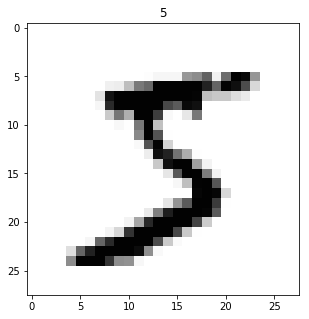

In [16]:
img, label = train[0]

print('image shape', tuple(img.shape))

# 最大値が 255 じゃなくて 1.0 なのでスケール変換はいらない
print('max value', torch.max(img).item())

plt.figure(figsize=(5,5))
plt.title(label)
plt.imshow(img[0, :, :], cmap='Greys') # img[channel, x, y] なので channel = 0 を表示
plt.show()

## DataLoader

Mini batch に切り分けてくれる


In [0]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

## ニューラルネットワークを定義

In [18]:
class ZeroNet(nn.Module):
    def __init__(self):
        # ここでは各レイヤーを定義しているだけ。繋がっていない
        # Sequential を使って __init__ 時点でつなぐ流儀もある
        super(ZeroNet, self).__init__()
        self.conv1a = nn.Conv2d(1,  16, 3, padding=1)  # 28x28x1 -> 28x28x16
        self.conv1b = nn.Conv2d(16, 16, 3, padding=1)  # 28x28x16 -> 28x28x16 
        self.pool1  = nn.MaxPool2d(2, 2)               # 28x28x16 -> 14x14x16
        self.conv2a = nn.Conv2d(16, 32, 3, padding=1)  # 14x14x16 -> 14x14x32
        self.conv2b = nn.Conv2d(32, 32, 3, padding=2)  # 14x14x32 -> 15x15x32
        self.pool2  = nn.MaxPool2d(2, 2)               # 15x15x32 -> 8x8x32
        self.conv3a = nn.Conv2d(32, 64, 3, padding=1)  # 8x8x32 -> 8x8x64
        self.conv3b = nn.Conv2d(64, 64, 3, padding=1)  # 8x8x64 -> 8x8x64
        self.pool3  = nn.MaxPool2d(2, 2)               # 8x8x64 -> 4x4x64
        self.fc1    = nn.Linear(64 * 4 * 4, 50)        # fully connected -> 50
        self.dropout1 = nn.Dropout2d()                 # default dropout rate is 0.5
        self.fc2      = nn.Linear(50, 10)              # 50 -> 10 number of classes
        self.dropout2 = nn.Dropout2d()

    def forward(self, x):
        # レイヤーをつなげている
        x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3a(x))
        x = F.relu(self.conv3b(x))
        x = self.pool3(x)
        
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.dropout2(x)

        return x

ZeroNet(
  (conv1a): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=50, bias=True)
  (dropout1): Dropout2d(p=0.5)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (dropout2): Dropout2d(p=0.5)
)

## Training
最小限のコードは

```python
epochs = 10

for iepoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader, 0): 
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
 ```

いろいろ測定と追加する

* かかった時間
* Loss と Accuracy

GPU を使うためには明示的に `to(device)` が必要

In [37]:
# Model と 最適化方法
model = ZeroNet()
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = model.to(device)  # send to GPU if available

# 訓練の進行具合を記録
def measure_scores(name, loader, history, *, nbatch=100):
    loss_sum = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader, 0):
            # send data to GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = model(images)
            loss = cross_entropy(outputs, labels)
            loss_sum += loss
            losses_test.append(loss.item())
                
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i + 1 == nbatch:
              break

    # average loss during the epoch
    loss_average = loss_sum / len(train_loader)
    accuracy = correct/total
    
    history[name + '_loss'].append(loss_average)
    history[name + '_accuracy'].append(accuracy)
            
            
epochs = 20
history = {'train_loss': [], 'test_loss': [],
           'train_accuracy': [], 'test_accuracy': []}

for iepoch in range(epochs):
    model.train()  # 訓練モード
    time_train = 0.0
    for i, (images, labels) in enumerate(train_loader, 0): 
        ts = time.time()
        
        # send data to GPU
        images = images.to(device)
        labels = labels.to(device)
            
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        te = time.time()
        time_train += (te - ts)
    
    times_train.append(time_train)
    
    # Measure test accuracy for each epoch
    ts = time.time()
    
    model.eval()  # evaluation モード; dropout しないなど
    
    measure_scores('train', train_loader, history)    
    measure_scores('test', test_loader, history)
    
    
    te = time.time()
    times_test.append(te - ts)
    
    print('Epoch %d: loss %.4e %.4e, Test accuracy %.6f' % (iepoch + 1,
          history['train_loss'][-1],
          history['test_loss'][-1],
          history['test_accuracy'][-1]))

    
print('Finished Training')
print('Training %.2f ± %.2f sec per epoch' % (np.mean(times_train), np.std(times_train)))
print('Test evaluation %.4f ± %.4f sec per epoch' % (np.mean(times_test), np.std(times_test)))
print('Total %.2f sec' % (np.sum(times_test) + np.sum(times_test)))

Epoch 1: loss 2.7997e-02 2.6356e-02, Test accuracy 0.972400
Epoch 2: loss 1.2067e-02 9.7272e-03, Test accuracy 0.986100
Epoch 3: loss 9.4106e-03 8.7298e-03, Test accuracy 0.985900
Epoch 4: loss 7.2840e-03 7.3446e-03, Test accuracy 0.988700
Epoch 5: loss 6.0206e-03 6.5785e-03, Test accuracy 0.988700
Epoch 6: loss 7.8819e-03 6.9845e-03, Test accuracy 0.989100
Epoch 7: loss 5.3222e-03 5.8031e-03, Test accuracy 0.990600
Epoch 8: loss 3.1463e-03 4.9049e-03, Test accuracy 0.991200
Epoch 9: loss 4.8375e-03 5.6565e-03, Test accuracy 0.989600
Epoch 10: loss 3.1438e-03 4.5006e-03, Test accuracy 0.993300
Epoch 11: loss 4.5520e-03 5.8513e-03, Test accuracy 0.990100
Epoch 12: loss 2.4366e-03 4.2349e-03, Test accuracy 0.993400
Epoch 13: loss 2.3012e-03 4.4349e-03, Test accuracy 0.992900
Epoch 14: loss 2.4307e-03 4.0303e-03, Test accuracy 0.992800
Epoch 15: loss 2.4302e-03 4.7802e-03, Test accuracy 0.993200
Epoch 16: loss 1.6848e-03 4.2504e-03, Test accuracy 0.993100
Epoch 17: loss 2.1489e-03 4.3145e

CPU mode Google collaboratory

### CPU

Google Colaboratory
```
Training 107.62 ± 1.49 sec per epoch
```

### GPU

Google Colaboratory Tesla T4

```
Training 2.55 ± 0.03 sec per epoch
Test evaluation 1.8030 ± 0.0218 sec per epoch
```


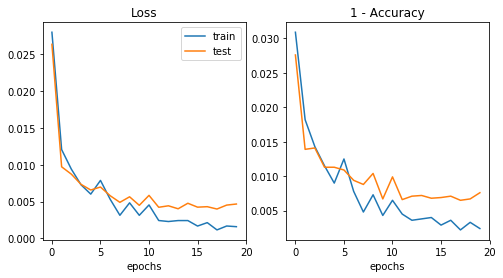

In [38]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('epochs')
plt.plot(history['train_loss'], label='train')
plt.plot(history['test_loss'], label='test')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('1 - Accuracy')
plt.xlabel('epochs')
plt.plot(1 - np.array(history['train_accuracy']))
plt.plot(1 - np.array(history['test_accuracy']))
plt.show()

## 疑問点

* Same padding って使う意味あるの？メモリと計算量の無駄な気がする
* cross_entropy 直前の10個のノードに dropout をかけるのはやり過ぎでは？ しかし、99% accuracy を達成してはいる。